In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller

temp_rain_soil = pd.read_csv("../AucklandCouncilOpenData_08June24/temp_rain_soil_Auckland_2015-10-21to2024-06-08.csv", index_col='Timestamp (UTC+12:00)', parse_dates=True)
temp_rain_soil.head()

,Temp,Rain(mm),SoilMoist,SoilTemp
Timestamp (UTC+12:00),,,,
2018-07-07 11:00:00,14.0,0.0,37.51600,10.400
2018-07-07 12:00:00,15.0,0.0,37.52375,10.600
2018-07-07 13:00:00,16.0,0.0,37.57200,10.700
2018-07-07 14:00:00,16.0,0.0,37.34300,10.725
2018-07-07 15:00:00,16.0,0.0,37.35050,10.950


In [10]:
temp_rain_soil.tail()

,Temp,Rain(mm),SoilMoist,SoilTemp
Timestamp (UTC+12:00),,,,
2023-08-23 00:00:00,11.0,0.0,50.77650,11.90
2023-08-23 01:00:00,11.0,0.0,50.82350,11.90
2023-08-23 02:00:00,11.0,0.0,50.82475,11.90
2023-08-23 03:00:00,11.0,0.0,50.85500,11.65
2023-08-23 04:00:00,10.0,0.0,50.95325,11.60


In [11]:
# Resample to daily mean values
temp_rain_soil_daily = temp_rain_soil.resample('D').mean()

In [12]:
def create_lag_features(data, lag_days):
    for i in range(1, lag_days + 1):
        for column in ['Temp', 'Rain(mm)']:
            data[f'lag_{column}_{i}'] = data[column].shift(i)
    data.dropna(inplace=True)
    return data
create_lag_features(temp_rain_soil, 14)

,Temp,Rain(mm),SoilMoist,SoilTemp,lag_Temp_1,lag_Rain(mm)_1,lag_Temp_2,lag_Rain(mm)_2,lag_Temp_3,lag_Rain(mm)_3,...,lag_Temp_10,lag_Rain(mm)_10,lag_Temp_11,lag_Rain(mm)_11,lag_Temp_12,lag_Rain(mm)_12,lag_Temp_13,lag_Rain(mm)_13,lag_Temp_14,lag_Rain(mm)_14
Timestamp (UTC+12:00),,,,,,,,,,,,,,,,,,,,,
2018-07-08 01:00:00,12.0,0.0,37.01475,11.20,13.0,0.0,13.0,0.0,13.0,0.0,...,16.0,0.0,16.0,0.0,16.0,0.0,15.0,0.0,14.0,0.0
2018-07-08 02:00:00,12.0,0.0,37.16300,11.15,12.0,0.0,13.0,0.0,13.0,0.0,...,15.0,0.0,16.0,0.0,16.0,0.0,16.0,0.0,15.0,0.0
2018-07-08 03:00:00,13.0,0.0,37.04450,11.10,12.0,0.0,12.0,0.0,13.0,0.0,...,15.0,0.0,15.0,0.0,16.0,0.0,16.0,0.0,16.0,0.0
2018-07-08 04:00:00,13.0,0.0,37.07950,11.10,13.0,0.0,12.0,0.0,12.0,0.0,...,15.0,0.0,15.0,0.0,15.0,0.0,16.0,0.0,16.0,0.0
2018-07-08 05:00:00,13.0,0.0,37.03725,11.10,13.0,0.0,13.0,0.0,12.0,0.0,...,14.0,0.0,15.0,0.0,15.0,0.0,15.0,0.0,16.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-23 00:00:00,11.0,0.0,50.77650,11.90,12.0,0.0,12.0,0.0,12.0,0.0,...,15.0,0.0,15.0,0.0,16.0,0.0,15.0,0.0,14.0,0.0
2023-08-23 01:00:00,11.0,0.0,50.82350,11.90,11.0,0.0,12.0,0.0,12.0,0.0,...,14.0,0.0,15.0,0.0,15.0,0.0,16.0,0.0,15.0,0.0
2023-08-23 02:00:00,11.0,0.0,50.82475,11.90,11.0,0.0,11.0,0.0,12.0,0.0,...,14.0,0.0,14.0,0.0,15.0,0.0,15.0,0.0,16.0,0.0


In [13]:
# Check stationarity using ADF test
result = adfuller(temp_rain_soil_daily['SoilMoist'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:')
for key, value in result[4].items():
    print(f'\t{key}: {value}')

ADF Statistic: -1.8390779177453187
p-value: 0.3612403358171127
Critical Values:
	1%: -3.4338839352172137
	5%: -2.8631010343251675
	10%: -2.5676010393524713


In [14]:
# Determine differencing term
d = 1 if result[1] > 0.05 else 0

# Determine AR and MA terms using ACF and PACF
lags = 50
variables = ['Temp', 'Rain(mm)', 'SoilMoist', 'SoilTemp']


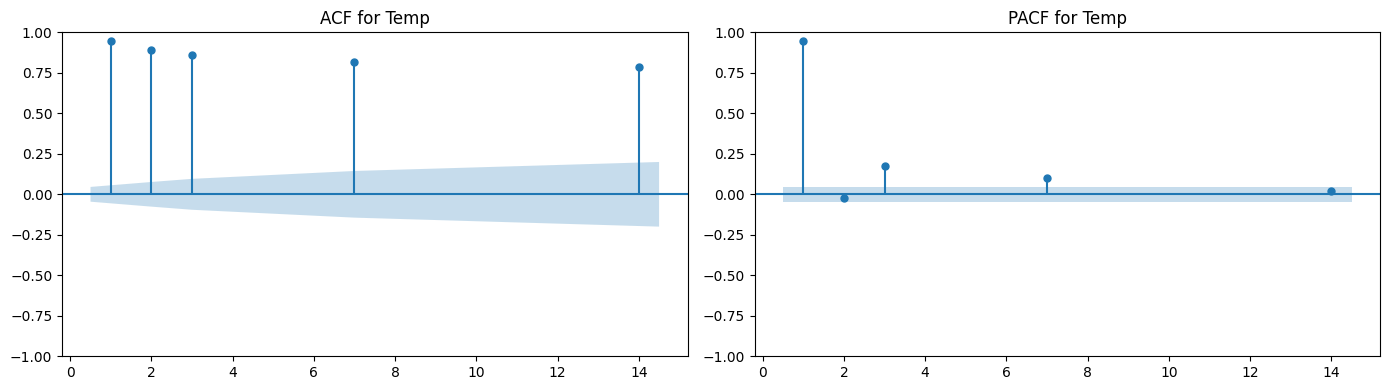

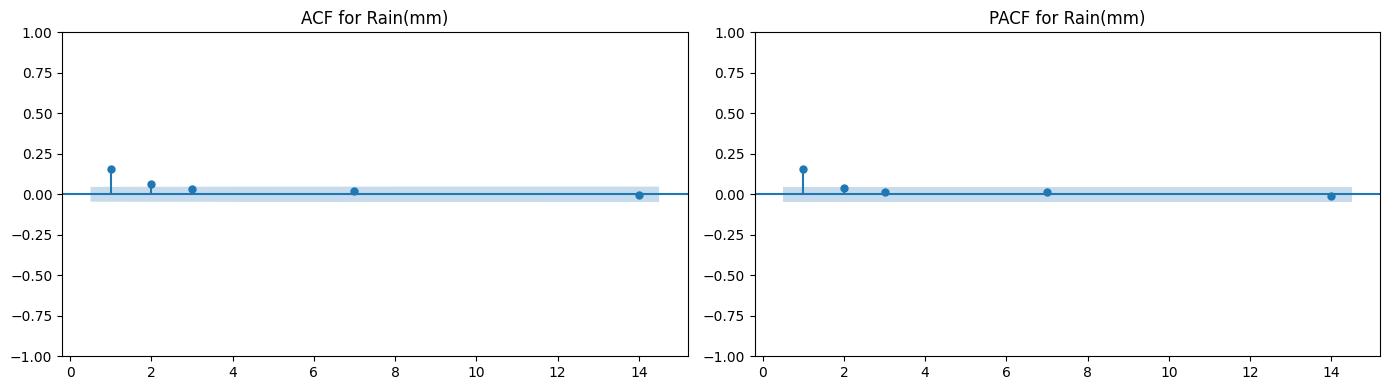

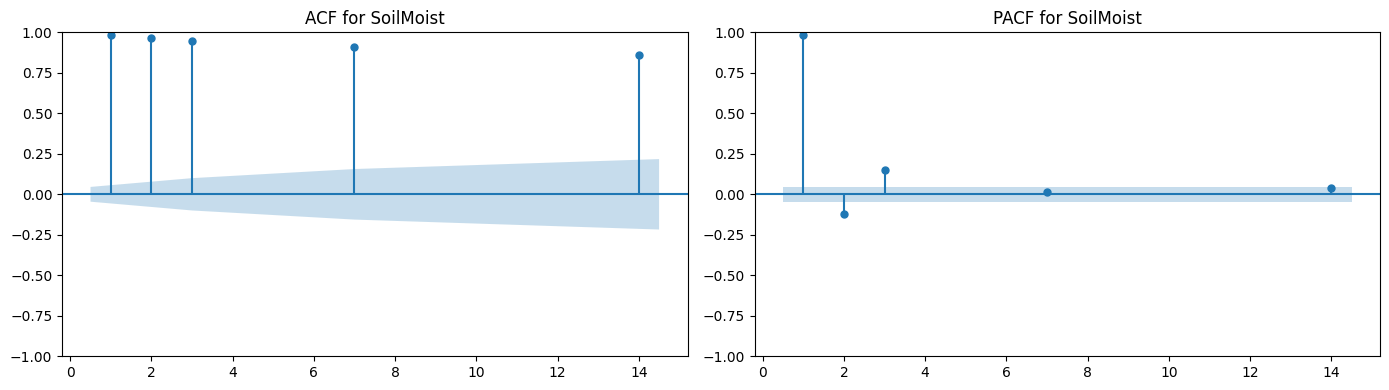

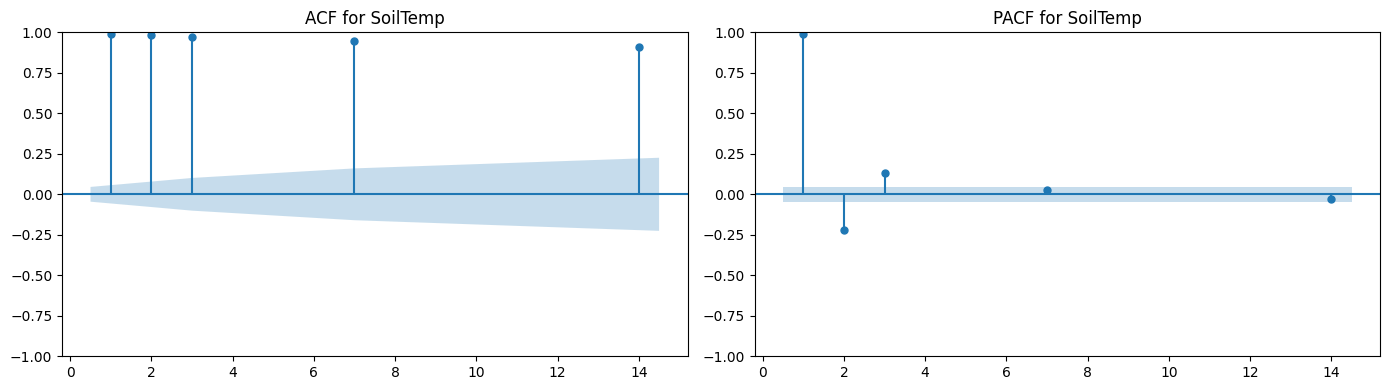

In [29]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

for var in variables:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))
    plot_acf(temp_rain_soil_daily[var], lags=lags, ax=ax1, title=f'ACF for {var}')
    plot_pacf(temp_rain_soil_daily[var], lags=lags, ax=ax2, title=f'PACF for {var}')
    plt.tight_layout()
    plt.show()

In [30]:
def create_lagged_features(df, lags):
    for lag in lags:
        df[f'SoilMoist_lag{lag}'] = df['SoilMoist'].shift(lag)
        df[f'Temp_lag{lag}'] = df['Temp'].shift(lag)
        df[f'Rain_lag{lag}'] = df['Rain(mm)'].shift(lag)
    return df

lags = [1, 2, 3, 7, 14]
df_lagged = create_lagged_features(temp_rain_soil_daily, lags)
df_lagged.dropna(inplace=True)

In [31]:
train_data_soil, test_data_soil = df_lagged['SoilMoist'][:-30], df_lagged['SoilMoist'][-30:]


In [32]:
# Fit the ARIMA model
p, q = 1, 1  # From ACF and PACF plots
model_soil_moist = ARIMA(train_data_soil, order=(p, d, q))
model_fit_soil_moist = model_soil_moist.fit()
print(model_fit_soil_moist.summary())


                               SARIMAX Results                                
Dep. Variable:              SoilMoist   No. Observations:                 1802
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -2214.059
Date:                Thu, 20 Jun 2024   AIC                           4434.118
Time:                        02:36:21   BIC                           4450.607
Sample:                    08-18-2018   HQIC                          4440.205
                         - 07-24-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4031      0.060     -6.705      0.000      -0.521      -0.285
ma.L1          0.5632      0.058      9.683      0.000       0.449       0.677
sigma2         0.6844      0.007     96.410      0.0

In [33]:
forecast = model_fit_soil_moist.forecast(steps=len(test_data_soil))
mse = mean_squared_error(test_data_soil, forecast)
print(f'Mean Squared Error (MSE): {mse}')

Mean Squared Error (MSE): 0.23377975106788365


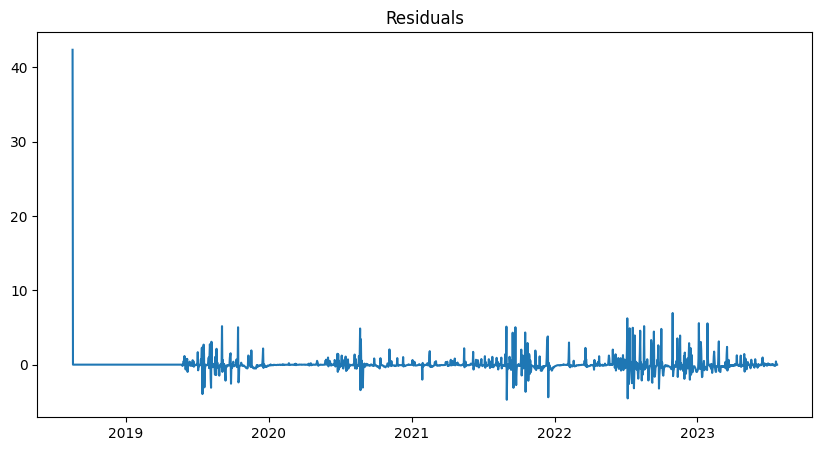

In [34]:
residuals = model_fit_soil_moist.resid
plt.figure(figsize=(10, 5))
plt.plot(residuals)
plt.title('Residuals')
plt.show()

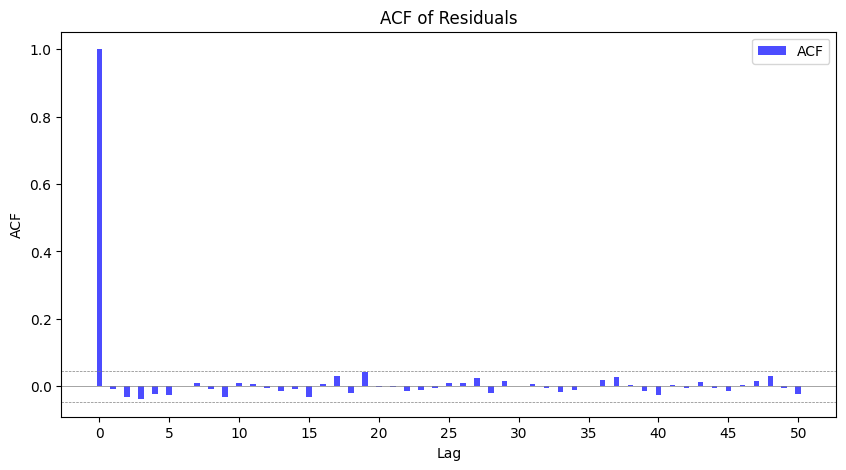

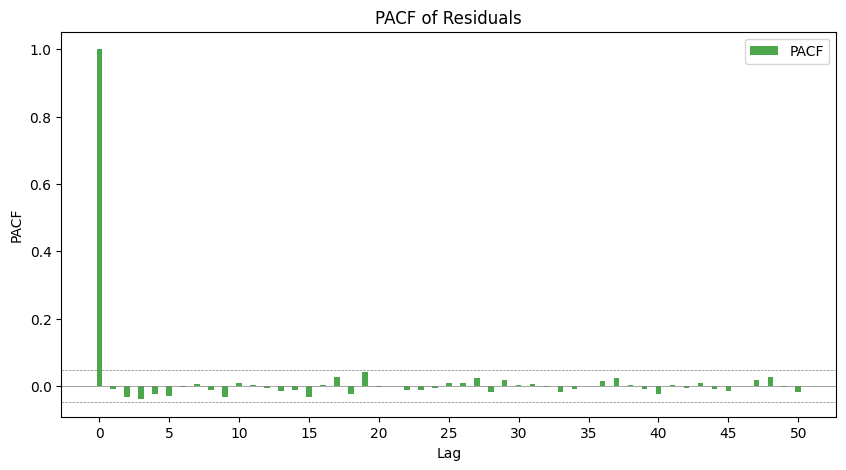

In [35]:
from statsmodels.tsa.stattools import acf, pacf

nlags = 50

acf_resid, acf_confint = acf(residuals, nlags=nlags, fft=True, alpha=0.05)
pacf_resid, pacf_confint = pacf(residuals, nlags=nlags, alpha=0.05)

# Plot ACF of residuals
plt.figure(figsize=(10, 5))
plt.bar(range(len(acf_resid)), acf_resid, width=0.4, color='b', alpha=0.7, label='ACF')
plt.title('ACF of Residuals')
plt.xlabel('Lag')
plt.ylabel('ACF')
plt.axhline(y=0, color='gray', linestyle='-', linewidth=0.5)
plt.axhline(y=-1.96/np.sqrt(len(residuals)), color='gray', linestyle='--', linewidth=0.5)
plt.axhline(y=1.96/np.sqrt(len(residuals)), color='gray', linestyle='--', linewidth=0.5)
plt.xticks(range(0, len(acf_resid), 5))
plt.legend(loc='upper right')
plt.show()

# Plot PACF of residuals
plt.figure(figsize=(10, 5))
plt.bar(range(len(pacf_resid)), pacf_resid, width=0.4, color='g', alpha=0.7, label='PACF')
plt.title('PACF of Residuals')
plt.xlabel('Lag')
plt.ylabel('PACF')
plt.axhline(y=0, color='gray', linestyle='-', linewidth=0.5)
plt.axhline(y=-1.96/np.sqrt(len(residuals)), color='gray', linestyle='--', linewidth=0.5)
plt.axhline(y=1.96/np.sqrt(len(residuals)), color='gray', linestyle='--', linewidth=0.5)
plt.xticks(range(0, len(pacf_resid), 5))
plt.legend(loc='upper right')
plt.show()